In [15]:
from IPython import get_ipython
get_ipython().magic('reset -sf') 

import numpy as np
import pandas as pd

# Data processing

## Census tract data

In [16]:
localpath = 'C:/Users/kli/OneDrive - Credit Union National Association, Inc/Branch Location/data_clean/'
file =  'tract_2010_demo.csv'
tract = pd.read_csv(localpath + file, dtype=object)

tract['tractid'] = tract['tractid'].astype('int64')
print(tract.shape)
tract.head()

(72779, 21)


,tractid,countyid,gisjoin,statea,poptotal,medincome,percapincome,ruca_prim,urbanization_bi,urbanization_tri,...,medincome_tri,medincome_cat,percapincome_bi,percapincome_tri,percapincome_cat,pop_density,white,black,asian,hispanic
0,1073002303,1073,G0100730002303,1,3.033,28.923,14.17,1,metro,urban,...,low and moderate,moderate,below,low and moderate,moderate,2.4483371,6.3303661,92.977249,0,0
1,1125010602,1125,G0101250010602,1,9.920999999999999,67.042,25.66,2,metro,urban,...,upper,upper,above,middle,middle,.19407202,94.153816,2.7819777,0,.83660918
2,1075030200,1075,G0100750030200,1,3.685,28.75,17.814,6,nonmetro,suburban,...,low and moderate,moderate,below,low and moderate,moderate,.01871114,89.199455,9.3894167,0,1.0312076
3,1121011800,1121,G0101210011800,1,2.909,19.192,11.659,4,nonmetro,suburban,...,low and moderate,low,below,low and moderate,moderate,2.1614432,76.211754,22.585081,0,3.0594707
4,1019956100,1019,G0100190956100,1,5.383,30.368,18.953,2,metro,urban,...,low and moderate,moderate,below,middle,middle,.03737314,91.120193,6.8177595,.48300204,1.7276611


In [17]:
## separate median income level by quartile levels for each state
tract['medincome'] = tract['medincome'].astype('float')
tract['percapincome'] = tract['percapincome'].astype('float')

Percentile = [25,50,75]

for percentile in Percentile:
    tract['medincome_' + str(percentile)] = (tract
                                             .groupby(['statea','urbanization_tri'], as_index=False)['medincome']
                                             .transform(lambda x: x.quantile(percentile/100)))
    
tract['medincome_quartile'] = np.nan
tract.loc[tract['medincome']<tract['medincome_25'], 'medincome_quartile'] = "Income: 1st quartile"
tract.loc[(tract['medincome']>=tract['medincome_25']) & (tract['medincome']<tract['medincome_50']), 'medincome_quartile'] = "Income: 2nd quartile"
tract.loc[(tract['medincome']>=tract['medincome_50']) & (tract['medincome']<tract['medincome_75']), 'medincome_quartile'] = "Income: 3rd quartile"
tract.loc[tract['medincome']>=tract['medincome_75'], 'medincome_quartile'] = "Income: 4th quartile"

# Notice statea==34, 44,9, 10

In [18]:
(tract
 .query('statea=="44" & urbanization_tri=="rural"')
 .filter(['tractid','poptotal','medincome', 'medincome_25', 'medincome_50','medincome_75','medincome_quartile']))

# (tract
#  .query('statea=="34" & urbanization_tri=="rural"')
#  .filter(['tractid','poptotal','medincome', 'medincome_25', 'medincome_50','medincome_75','medincome_quartile']))

# (tract
#  .query('statea=="34" & urbanization_tri=="suburban"')
#  .filter(['tractid','poptotal','medincome', 'medincome_25', 'medincome_50','medincome_75','medincome_quartile']))

# (tract
#  .query('statea=="9" & urbanization_tri=="rural"')
#  .filter(['tractid','poptotal','medincome', 'medincome_25', 'medincome_50','medincome_75','medincome_quartile']))

# (tract
#  .query('statea=="10" & urbanization_tri=="rural"')
#  .filter(['tractid','poptotal','medincome', 'medincome_25', 'medincome_50','medincome_75','medincome_quartile']))

,tractid,poptotal,medincome,medincome_25,medincome_50,medincome_75,medincome_quartile
58510,44009990100,0,NaN,75.417,75.417,75.417,NaN
58547,44009041500,.914,75.417,75.417,75.417,75.417,Income: 4th quartile


In [19]:
## diversity
tract['white'] = tract['white'].astype(float)
tract['diversity'] = np.where(tract['white'] < tract['white'].median(), 'diverse (white share < median)', 'non-diverse (white share >= median)')
tract.loc[tract['white']!=tract['white'], 'diversity'] = np.nan

tract.fillna(-1).groupby('diversity').count()['tractid']  # a workaround to show nan counts

diversity
-1                                       408
diverse (white share < median)         36185
non-diverse (white share >= median)    36186
Name: tractid, dtype: int64

In [20]:
tract.to_csv(localpath + 'tract_2010_demo_new.csv', index=False)

## Branch data

In [21]:
mainpath = 'O:/Econ/Stata Files/BranchData/'
subpath = 'Branch GeoID processed/'

branch_cuna = {}
branch_bank = {}

Year = ['2006','2011', '2016', '2018']

for year in Year:
    branch_cuna[year] = (pd.read_csv(mainpath + subpath + 'branch_cuna_' + year + '.csv', dtype=object)
                         .filter(['x','y', 'cuid', 'geoid','year'])
                         .rename(columns={'geoid':'tractid'}))
    
for year in Year:
    branch_bank[year] = (pd.read_csv(mainpath + subpath + 'branch_fdic_' + year + '.csv', dtype=object)
                         .filter(['x','y', 'cert', 'geoid','year'])
                         .rename(columns={'geoid':'tractid'}))

## Call report data

In [22]:
subpath = "Call Report/"
cuna = (pd.read_csv(mainpath + subpath + "CallReport - CU Branch.csv", dtype=object)
        .filter(['cuid', 'assets', 'NA'])
        .assign(year=lambda x: ((x.NA.astype(int)-6)/100).astype(int))
        .query('year==2006 | year==2011 | year==2016 | year==2018')
        .drop(columns=['NA']))

bank = (pd.read_csv(mainpath + subpath + "CallReport - Bank Branch.csv", dtype=object)
        .filter(['cert', 'assets', 'NA'])
        .assign(year=lambda x: ((x.NA.astype(int)-6)/100).astype(int))
        .query('year==2006 | year==2011 | year==2016 | year==2018')
        .drop(columns=['NA']))

## Merging & appending data

In [23]:
## cuna
df_cuna = pd.DataFrame()

for year in branch_cuna:
    df_cuna = pd.concat([df_cuna, branch_cuna[year]], ignore_index=True)
    
df_cuna['tractid'] = df_cuna['tractid'].astype('int64')  # it is because tract file does not keep the first 0    
print(df_cuna['tractid'].nunique())

## merge with assets
df_cuna['year'] = df_cuna['year'].astype(int)
df_cuna = df_cuna.merge(cuna, on=['cuid','year'], how='left', indicator=True)
print(df_cuna.groupby('_merge').count())  # 8 left only

df_cuna = (df_cuna
           .query('_merge=="both"')
           .drop(columns=['_merge']))

df_cuna = df_cuna.merge(tract, on='tractid', how='left', indicator=True, validate='many_to_one')
df_cuna.groupby('_merge').count()  # there are 144 unmatched, why?
df_cuna = df_cuna.query('_merge=="both"').drop(columns=['_merge'])
df_cuna['year'] = df_cuna['year'].astype(int)
df_cuna['assets'] = df_cuna['assets'].astype(float)/1000

# df_cuna.query('_merge=="both" & percapincome_cat!=percapincome_cat').shape   # 352 such obs

18461
                x      y   cuid  tractid   year  assets
_merge                                                 
left_only       8      8      8        8      8       0
right_only      0      0      0        0      0       0
both        78782  78782  78782    78782  78782   78782


In [24]:
## bank
df_bank = pd.DataFrame()

for year in branch_bank:
    df_bank = pd.concat([df_bank, branch_bank[year]], ignore_index=True)
    
df_bank.dropna(subset=['tractid'], inplace=True) # why there is nondefined tractid?
df_bank['tractid'] = df_bank['tractid'].astype('int64')
print(df_bank['tractid'].nunique())


## merge with assets
df_bank['year'] = df_bank['year'].astype(int)
df_bank = df_bank.merge(bank, on=['cert','year'], how='left', indicator=True)
print(df_bank.groupby('_merge').count())  # 5 left only

df_bank = (df_bank
           .query('_merge=="both"')
           .drop(columns=['_merge']))


## merge with census data
df_bank = df_bank.merge(tract, on='tractid', how='left', indicator=True, validate='many_to_one')
print(df_bank.groupby('_merge').count()['tractid'])  # there are 170 unmatched, why?
df_bank = df_bank.query('_merge=="both"').drop(columns=['_merge'])
df_bank['assets'] = df_bank['assets'].astype(float)


39663
                 x       y    cert  tractid    year  assets
_merge                                                     
left_only        5       5       5        5       5       0
right_only       0       0       0        0       0       0
both        346593  346593  346593   346593  346593  346593
_merge
left_only        170
right_only         0
both          346423
Name: tractid, dtype: int64


In [25]:
## new variable and rename
df_cuna['InstType'] = "Credit Unions"
df_cuna.rename(columns={'cuid':'Instid'}, inplace=True)

ten_billion = 1E+7
df_bank['assets'] = df_bank['assets'].astype('float64')
df_bank['InstType'] = np.where(df_bank['assets']>=ten_billion, "Large Banks", "Community Banks")
df_bank.rename(columns={'cert':'Instid'}, inplace=True)

df = pd.concat([df_cuna, df_bank], ignore_index=True)

In [26]:
df.loc[df['InstType']=="Credit Unions", 'InstType2'] = "Credit Unions"
df.loc[df['InstType']!="Credit Unions", 'InstType2'] = "Banks"

# Plot

In [27]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns 
import plot_aes as paes

%matplotlib inline
sns.set()

# sns.set_style('white')
sns.set_style('white')
sns.set_palette("Set2")
savepath = '../../outputs/graphs/proportion_total/'

Income = ['Income: 1st quartile','Income: 2nd quartile','Income: 3rd quartile','Income: 4th quartile']
Urb = ['rural','suburban', 'urban']
Div = ['diverse (white share < median)', 'non-diverse (white share >= median)']

## Save branch counts by urbanization

In [ ]:
mainpath = 'O:/Econ/Stata Files/BranchData/'

## for income 
df_save = (df
           .groupby(['year','InstType','urbanization_tri','medincome_quartile'], as_index=False)['Instid']
           .count()
           .rename(columns={'Instid':'total'}))

df_save.to_csv(mainpath + 'branchcount_urb_income.csv', index=False)

## for diversity
df_save = (df
           .groupby(['year','InstType','urbanization_tri','diversity'], as_index=False)['Instid']
           .count()
           .rename(columns={'Instid':'total'}))

df_save.to_csv(mainpath + 'branchcount_urb_diversity.csv', index=False)

In [28]:
df['medincome_quartile'].unique()

array(['Income: 1st quartile', 'Income: 2nd quartile',
       'Income: 3rd quartile', 'Income: 4th quartile', nan], dtype=object)

## Counts of institutions

134.8175


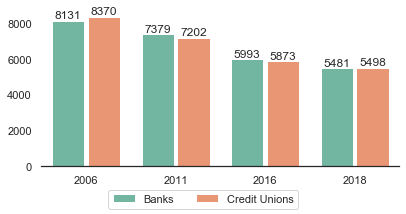

In [29]:
df_plot =  (df.drop_duplicates(subset=['InstType2','Instid','year'],keep='first')
            .groupby(['year', 'InstType2'], as_index=False)['Instid']
            .count()
            .rename(columns={'Instid':'total'}))

g = sns.catplot('year','total',
                hue='InstType2', 
                hue_order = ['Banks', 'Credit Unions'],
                kind='bar', height=3, aspect=2, legend=False, data=df_plot)    

heights = [p.get_height() for p in g.ax.patches]
above = np.mean(heights)/50
print(above)

for p in g.ax.patches:
    height = p.get_height()
    width = p.get_width()
    width_new = width * 0.9
    width_diff = width - width_new
    
    p.set_width(width_new)
    p.set_x(p.get_x() + width_diff/2)
    g.ax.text(p.get_x() + p.get_width()/2.,
             height + above,
             int(height),
             ha="center") 
    
g.despine(left=True)
g.set_axis_labels("","")
g.fig.legend(loc='lower center', ncol=3, borderaxespad=0.5)
g.savefig(savepath + 'inst_counts.png')

## Counts of branches

1062.6525


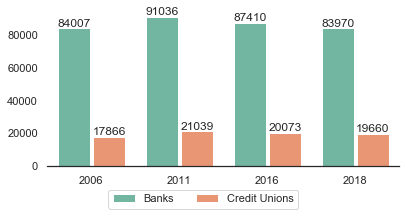

In [30]:
df_plot =  (df
            .groupby(['year', 'InstType2'], as_index=False)['Instid']
            .count()
            .rename(columns={'Instid':'total'}))

g = sns.catplot('year','total',
                hue='InstType2', 
                hue_order = ['Banks', 'Credit Unions'],
                kind='bar', height=3, aspect=2, data=df_plot, legend=False)

heights = [p.get_height() for p in g.ax.patches]
above = np.mean(heights)/50
print(above)

for p in g.ax.patches:
    height = p.get_height()
    width = p.get_width()
    width_new = width * 0.9
    width_diff = width - width_new
    
    p.set_width(width_new)
    p.set_x(p.get_x() + width_diff * 1/2)
    g.ax.text(p.get_x()+p.get_width()/2.,
             height + above,
             int(height),
             ha="center")
    
g.despine(left=True)
g.set_axis_labels("","")
g.fig.legend(loc='lower center', ncol=3, borderaxespad=0.5)
g.savefig(savepath + 'branch_counts.png')
plt.show()

## Assets

2013.55572625


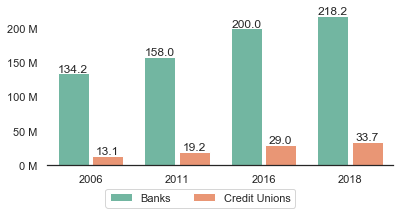

In [32]:
df_plot =  (df.drop_duplicates(subset=['InstType2','Instid','year'],keep='first')
            .groupby(['year', 'InstType2'], as_index=False)
            .agg({'assets':'median'}))

g = sns.catplot('year','assets',
                hue='InstType2', 
                hue_order = ['Banks', 'Credit Unions'],
                kind='bar', height=3, aspect=2, legend=False, data=df_plot)    

heights = [p.get_height() for p in g.ax.patches]
above = np.mean(heights)/50
print(above)

for p in g.ax.patches:
    height = p.get_height()
    width = p.get_width()
    width_new = width * 0.9
    width_diff = width - width_new
    
    p.set_width(width_new)
    p.set_x(p.get_x() + width_diff/2)
    g.ax.text(p.get_x() + p.get_width()/2.,
             height + above,
             round(height/1000,1),
             ha="center") 
    
g.despine(left=True)
g.set_axis_labels("","")
ylabels = ['{:,.0f}'.format(x) + ' M' for x in g.ax.get_yticks()/1000]
g.set_yticklabels(ylabels)
g.fig.legend(loc='lower center', ncol=3, borderaxespad=0.5)
          
# g.fig.suptitle('Institution counts for each type', fontsize=13, x=0.6)
g.savefig(savepath + 'inst_assets_median.png')

## Proportion of branches by income level

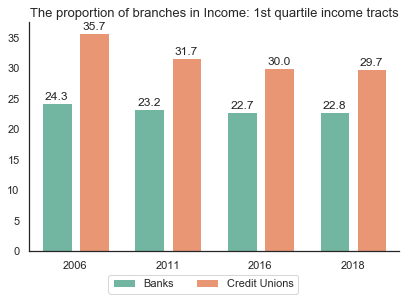

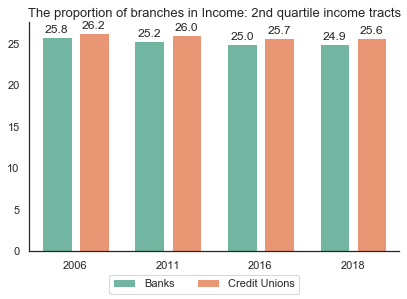

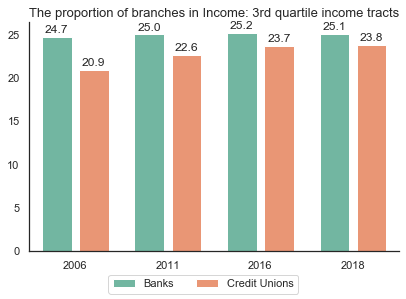

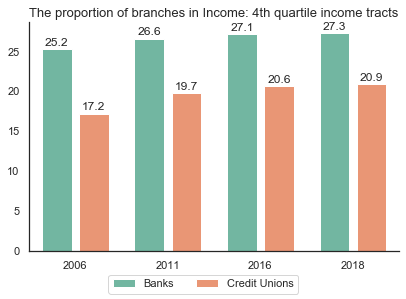

In [33]:
df_plot =  (df
            .groupby(['year', 'InstType2', 'medincome_quartile'], as_index=False)['x']
            .count()
            .rename(columns={'x':'count'}))

df_plot['total'] = df_plot.groupby(['year','InstType2'], as_index=False)['count'].transform(sum)
df_plot['proportion'] = df_plot['count']/df_plot['total'] * 100

# save them separately
for income in Income:
    df_plot_sub = df_plot[df_plot.medincome_quartile==income]
    g = sns.catplot('year','proportion',
                    hue='InstType2', 
#                     hue_order = ['Large Banks', 'Community Banks', 'Credit Unions'],
                    hue_order = ['Banks', 'Credit Unions'],                    
                    kind='bar', 
                    height=4, aspect=3/2,legend=False, data=df_plot_sub)
    
    g = paes.catplot_bar(g, 0.8,1, "","")   
    
    g.fig.legend(loc='lower center', ncol=3, borderaxespad=0.5) 
    plt.title('The proportion of branches in ' + income + ' income tracts', fontsize=13)
    plt.savefig(savepath + 'Income/' + income + '.png')
    plt.show()

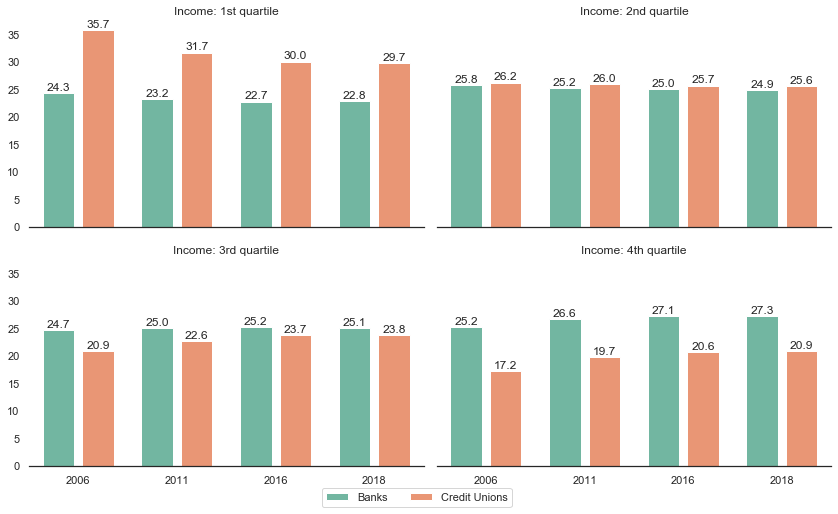

In [34]:
## put them together 
g = sns.catplot('year','proportion',
                col = 'medincome_quartile', col_order = Income, col_wrap=2,
                hue='InstType2', 
#                 hue_order = ['Large Banks', 'Community Banks', 'Credit Unions'],
                hue_order = ['Banks', 'Credit Unions'],
                kind='bar', 
                height=3.6, aspect=5/3, 
                legend=False,
                data=df_plot)

g = paes.catplot_bar_col(g, 0.8,1, "","")   
g.despine(left=True)
plt.legend(loc='lower center', bbox_to_anchor = (-0.05, -0.2),ncol=3, borderaxespad=0) 
# g.add_legend(loc='lower center',bbox_to_anchor = (0.35, 0), ncol=3, borderaxespad=0) 

# g.fig.suptitle('Proportion of branches by income level', x=0.5, y=1)
plt.savefig(savepath + 'Income/income.png')
plt.show()

## Proportion of branches by urbanization

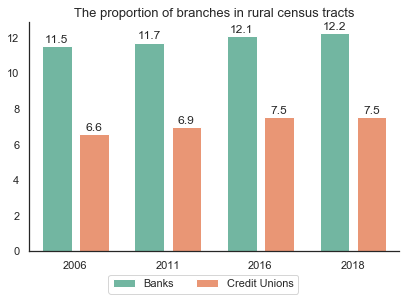

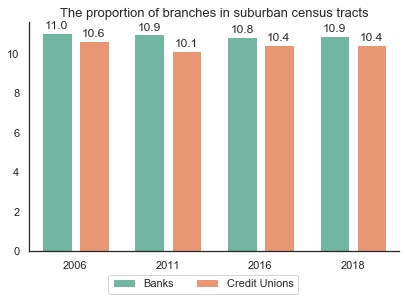

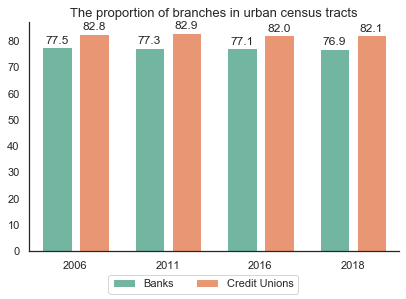

In [35]:
df_plot =  (df
            .groupby(['year', 'InstType2', 'urbanization_tri'], as_index=False)['x']
            .count()
            .rename(columns={'x':'count'}))

df_plot['total'] = df_plot.groupby(['year','InstType2'], as_index=False)['count'].transform(sum)
df_plot['proportion'] = df_plot['count']/df_plot['total'] * 100

# save separately
for urb in Urb:
    df_plot_sub=df_plot[df_plot.urbanization_tri==urb]
    g = sns.catplot('year','proportion',
                    hue='InstType2', 
#                     hue_order = ['Large Banks', 'Community Banks', 'Credit Unions'],
                    hue_order = ['Banks', 'Credit Unions'],                   
                    kind='bar', height=4, aspect=3/2,legend=False,data=df_plot_sub)

    g = paes.catplot_bar(g, 0.8,1, "","")   
    g.fig.legend(loc='lower center', ncol=3, borderaxespad=0.5) 
    plt.title('The proportion of branches in ' + urb + ' census tracts', fontsize=13)
    g.savefig(savepath + 'Urbanization/' + urb + '.png')

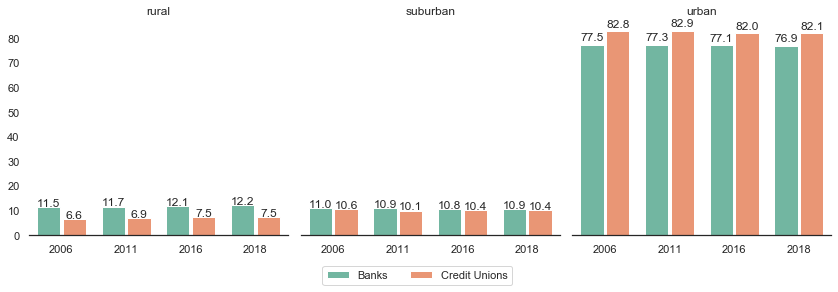

In [36]:
## put them together 
g = sns.catplot('year','proportion',
                col = 'urbanization_tri', col_order = Urb, col_wrap=3,
                hue='InstType2', 
#                 hue_order = ['Large Banks', 'Community Banks', 'Credit Unions'],
                hue_order = ['Banks', 'Credit Unions'],
                kind='bar', 
                height=4, aspect=1,legend=False, data=df_plot)

g = paes.catplot_bar_col(g, 0.9,1, "","")   
g.despine(left=True)
plt.legend(loc='lower center', bbox_to_anchor = (-0.6, -0.23),ncol=3, borderaxespad=0) 
# g.fig.suptitle('Proportion of branches by Urbanization level', x=0.45, y=1.01, fontsize=12)
plt.savefig(savepath + 'Urbanization/urbanization.png')
plt.show()

## Proportion of branches by diversity

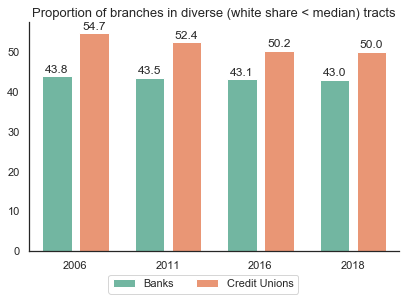

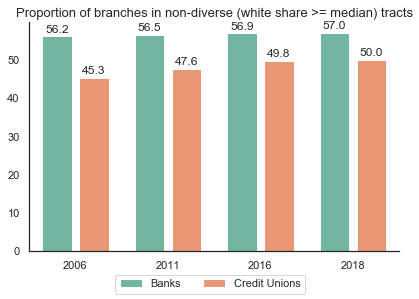

In [37]:
df_plot = (df
            .groupby(['year', 'InstType2', 'diversity'], as_index=False)['x']
            .count()
            .rename(columns={'x':'count'}))

df_plot['total'] = df_plot.groupby(['year','InstType2'], as_index=False)['count'].transform(sum)
df_plot['proportion'] = df_plot['count']/df_plot['total'] * 100

# save separately
for div in Div:
    df_plot_sub=df_plot[df_plot.diversity==div]
    g = sns.catplot('year','proportion',
                    hue='InstType2', 
#                     hue_order = ['Large Banks', 'Community Banks', 'Credit Unions'],
                    hue_order = ['Banks', 'Credit Unions'],
                    kind='bar', height=4, aspect=3/2,legend=False, data=df_plot_sub)

    g = paes.catplot_bar(g, 0.8,1, "","")   
    g.fig.legend(loc='lower center', ncol=3, borderaxespad=0.5) 

    plt.title('Proportion of branches in ' + div + ' tracts',fontsize=13)
    div_save = div.split(" (")[0]
    g.savefig(savepath + 'Diversity/' + div_save + '.png')

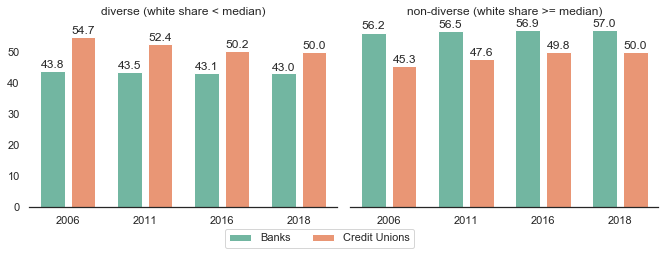

In [38]:
## put them together 
g = sns.catplot('year','proportion',
                col = 'diversity', col_order = Div, col_wrap=2,
                hue='InstType2', 
#                 hue_order = ['Large Banks', 'Community Banks', 'Credit Unions'],
                hue_order = ['Banks', 'Credit Unions'],
                kind='bar', 
                height=3.6, aspect=4/3,legend=False, data=df_plot)

g = paes.catplot_bar_col(g, 0.8,1, "","")   

g.despine(left=True)
plt.legend(loc='lower center', bbox_to_anchor = (-0.1, -0.22),ncol=3, borderaxespad=0) 
# g.fig.suptitle('Proportion of branches by ethnicity diversity', x=0.5, y=1.01)
plt.savefig(savepath + 'Diversity/diversity.png')
plt.show()

## Proportion of branches by income level, given urbanization level

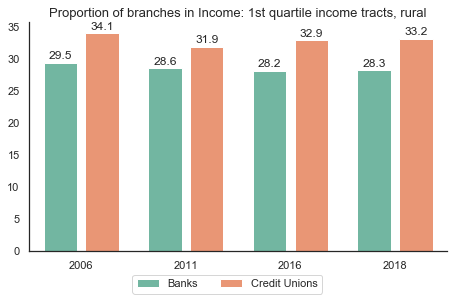

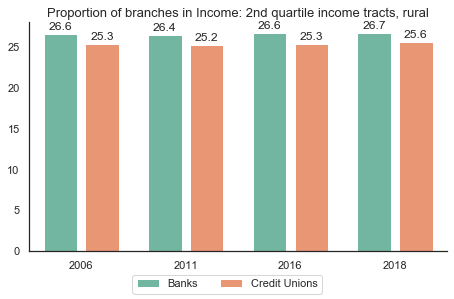

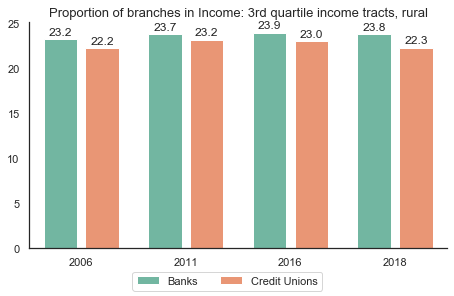

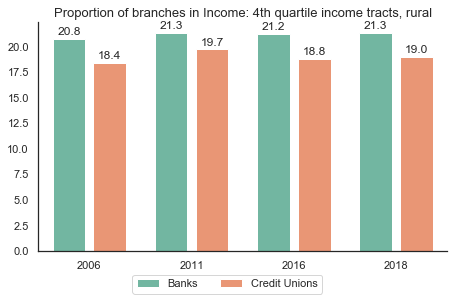

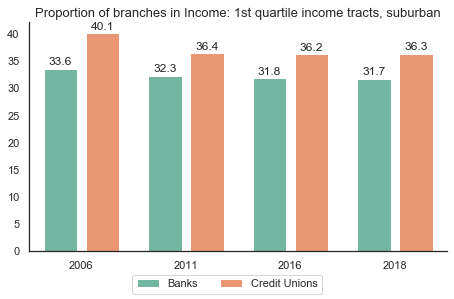

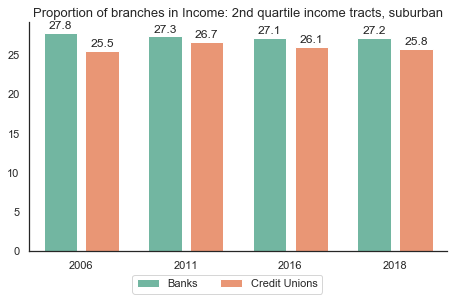

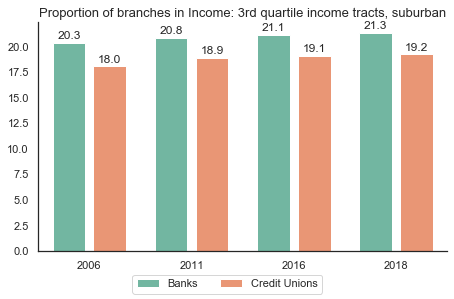

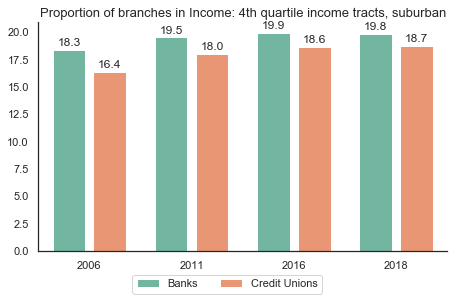

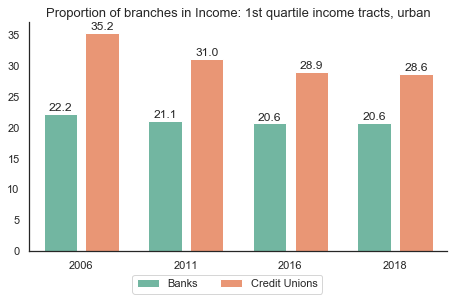

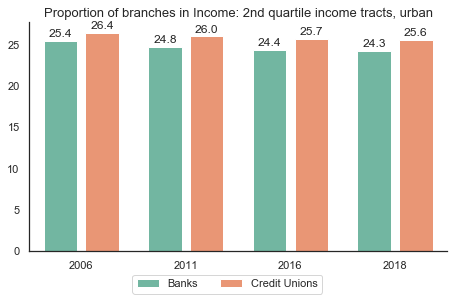

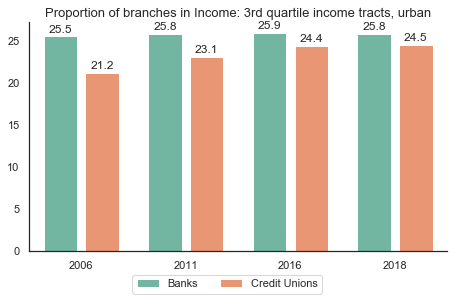

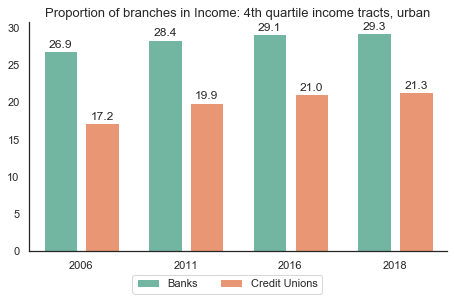

In [39]:
for urb in Urb:
    df_plot =  (df[df['urbanization_tri']==urb]
                .groupby(['year', 'InstType2', 'medincome_quartile'], as_index=False)['x']
                .count()
                .rename(columns={'x':'count'}))

    df_plot['total'] = df_plot.groupby(['year','InstType2'], as_index=False)['count'].transform(sum)
    df_plot['proportion'] = df_plot['count']/df_plot['total'] * 100

    for income in Income:
        df_plot_sub = df_plot[df_plot.medincome_quartile==income]
        g = sns.catplot('year','proportion',
                        hue='InstType2', 
#                         hue_order = ['Large Banks', 'Community Banks', 'Credit Unions'],
                        hue_order = ['Banks', 'Credit Unions'],
                        kind='bar', height=4, aspect=5/3, legend=False, data=df_plot_sub)
        
        g = paes.catplot_bar(g, 0.8,1, "","")   
        g.fig.legend(loc='lower center', ncol=3, borderaxespad=0.5) 
        plt.title('Proportion of branches in ' + income + ' income tracts, ' + urb, fontsize=13)
        g.savefig(savepath + 'Income_by_Urbanization/' + income + '_' + urb + '.png')

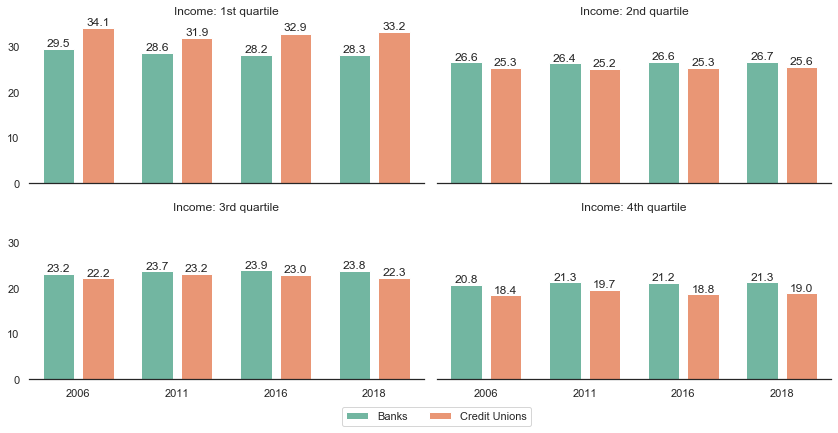

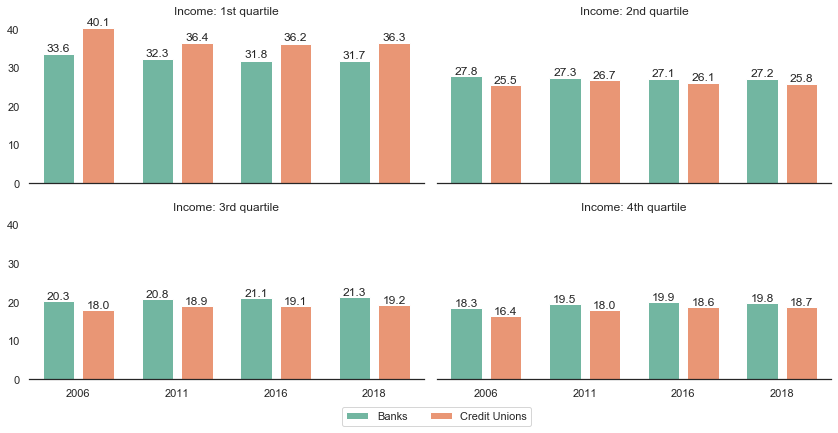

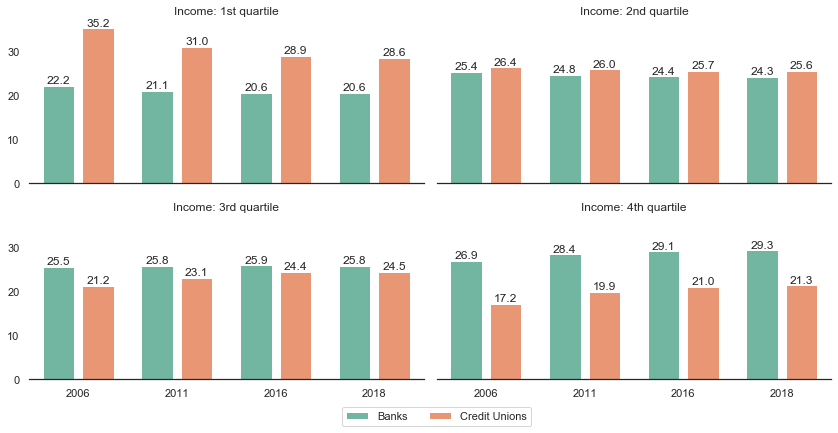

In [40]:
for urb in Urb:
    df_plot =  (df[df['urbanization_tri']==urb]
                .groupby(['year', 'InstType2', 'medincome_quartile'], as_index=False)['x']
                .count()
                .rename(columns={'x':'count'}))

    df_plot['total'] = df_plot.groupby(['year','InstType2'], as_index=False)['count'].transform(sum)
    df_plot['proportion'] = df_plot['count']/df_plot['total'] * 100

    g = sns.catplot('year','proportion',
                    col ='medincome_quartile', col_order=Income, col_wrap=2, 
                    hue='InstType2', 
#                     hue_order = ['Large Banks', 'Community Banks', 'Credit Unions'],
                    hue_order = ['Banks', 'Credit Unions'],        
                    kind='bar', height=3, aspect=2, legend=False, data=df_plot)

    g = paes.catplot_bar_col(g, 0.8,1, "","") 
    g.despine(left=True)
    plt.legend(loc='lower center', bbox_to_anchor=(0,-0.32), ncol=3, borderaxespad=0.5) 
#     g.fig.suptitle('Proportion of branches by income level, ' + urb, fontsize=13, y=1.02)
    g.savefig(savepath + 'Income_by_Urbanization/income' + '_' + urb + '.png')

## Proportion of branches by diversity level, given urbanization level

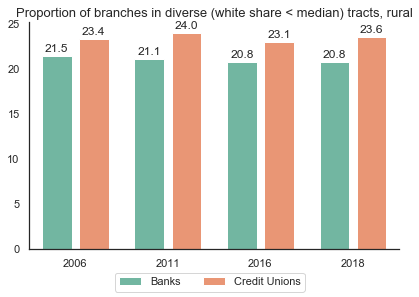

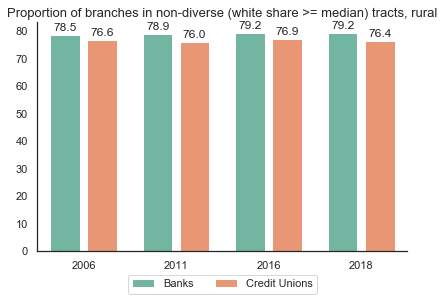

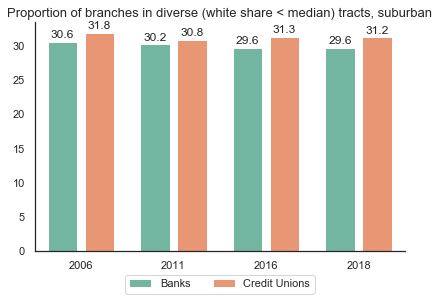

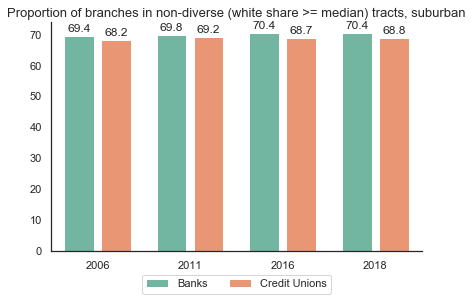

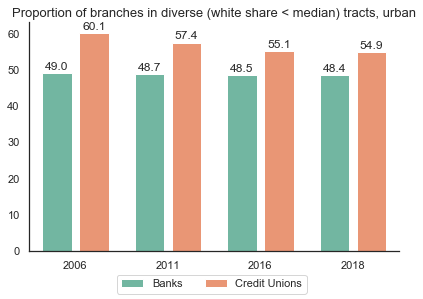

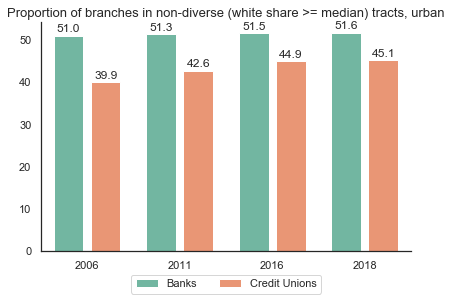

In [41]:
for urb in Urb:
    df_plot =  (df[df['urbanization_tri']==urb]
                .groupby(['year', 'InstType2', 'diversity'], as_index=False)['x']
                .count()
                .rename(columns={'x':'count'}))

    df_plot['total'] = df_plot.groupby(['year','InstType2'], as_index=False)['count'].transform(sum)
    df_plot['proportion'] = df_plot['count']/df_plot['total'] * 100
    
    for div in Div:
        df_plot_sub = df_plot[df_plot.diversity == div]
        g = sns.catplot('year','proportion',
                        hue='InstType2', 
#                         hue_order = ['Large Banks', 'Community Banks', 'Credit Unions'],
                        hue_order = ['Banks', 'Credit Unions'],
                        kind='bar', height=4, aspect=3/2, legend=False, data=df_plot_sub)
        
        g = paes.catplot_bar(g, 0.8,1, "","")
        g.fig.legend(loc='lower center', ncol=3, borderaxespad=0.5)
        plt.title('Proportion of branches in ' + div + ' tracts, ' + urb, fontsize=13)
        div_save = div.split(' (')[0]
        g.savefig(savepath + 'Diversity_by_Urbanization/' + div_save + '_' + urb + '.png')

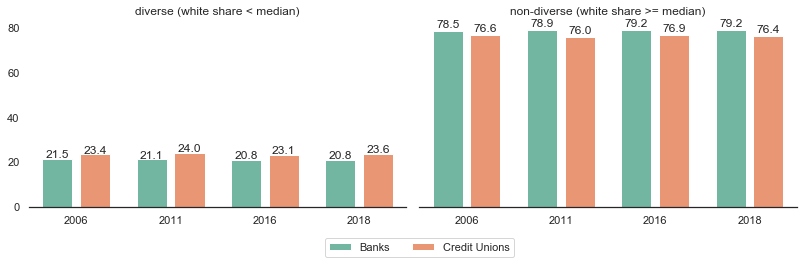

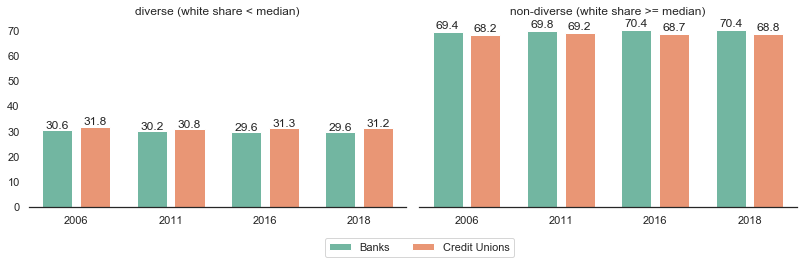

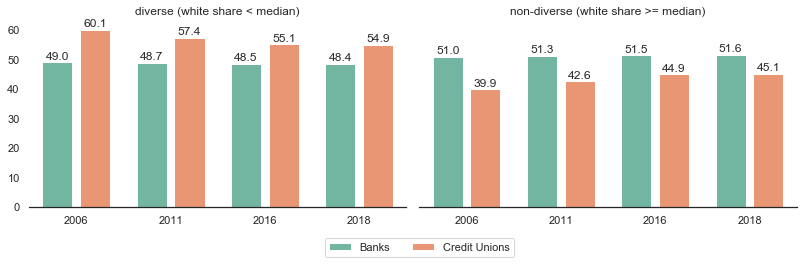

In [42]:
for urb in Urb:
    df_plot =  (df[df['urbanization_tri']==urb]
                .groupby(['year', 'InstType2', 'diversity'], as_index=False)['x']
                .count()
                .rename(columns={'x':'count'}))

    df_plot['total'] = df_plot.groupby(['year','InstType2'], as_index=False)['count'].transform(sum)
    df_plot['proportion'] = df_plot['count']/df_plot['total'] * 100
    
    g = sns.catplot('year','proportion',
                    col='diversity', col_order=Div, col_wrap=2, 
                    hue='InstType2', 
#                     hue_order = ['Large Banks', 'Community Banks', 'Credit Unions'],
                    hue_order = ['Banks', 'Credit Unions'],
                    kind='bar', height=3.6, aspect=3.2/2, legend=False, data=df_plot)

    g = paes.catplot_bar_col(g, 0.8,1, "","")
    g.despine(left=True)
    plt.legend(loc='lower center', bbox_to_anchor=(0,-0.3), ncol=3, borderaxespad=0.5)
#     g.fig.suptitle('Proportion of branches by ethnicity diversity, ' + urb, y = 1.02)
    div_save = div.split(' (')[0]
    g.savefig(savepath + 'Diversity_by_Urbanization/diversity' + '_' + urb + '.png')